In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
import scipy
import glob
from matplotlib.patches import Rectangle

Matplotlib created a temporary config/cache directory at /localscratch/672006/matplotlib-34icqw2t because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
%matplotlib notebook
plt.style.use('seaborn')

In [3]:
#where the results are located
inDir='/groups/SIAllocation/tsunami/1852_results/24k-runs'
inDir='/projects/SIAllocation/tsunami/1852_results/24k-runs'
#chains
# chains = os.listdir(inDir)
dirs = glob.glob(inDir+"/3*/")

In [4]:
#read in data
nburn=0 #rows to skip at the start of each chain

samples = []
model_params = []
model_output = []
bayes_data = []
debug = []
data = (['samples','model_params','model_output','bayes_data','debug'],
             [samples,model_params,model_output,bayes_data,debug])

for dir_ in dirs:
    for kind,lst in zip(*data):
        k=nburn+1
        if kind=='debug':
            k=nburn
        df = pd.read_csv(dir_+kind+'.csv',index_col=0).iloc[k:].reset_index(drop=True)
#         df['chain_id'] = dir_[:-4]
        lst.append(df)

In [5]:
#read in data
#dfs = [ pd.read_csv(inDir+"/"+chain+"/samples.csv") for chain in chains ]
samples[0].iloc[5999:6003, :].head()

,latitude,longitude,magnitude,delta_logl,delta_logw,depth_offset
5999,-5.749850,131.677695,8.559023,-0.376684,-0.136466,4.136564
6000,-4.445128,131.771924,8.822047,-0.140194,-0.328019,9.433089
6001,-4.445128,131.771924,8.822047,-0.140194,-0.328019,9.433089
6002,-4.445128,131.771924,8.822047,-0.140194,-0.328019,9.433089


<IPython.core.display.Javascript object>


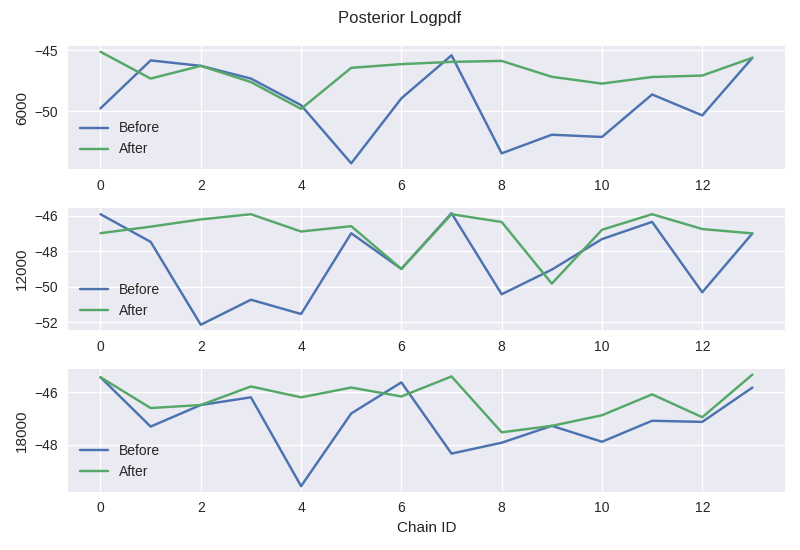

In [6]:
attr = 'posterior_logpdf'
dfs  = debug
resampIdx = [6000, 12000, 18000 ]


fig,axs = plt.subplots(len(resampIdx))
fig.suptitle(attr.replace('_',' ').title())
for j,ax in enumerate(axs.ravel()):
    idx = resampIdx[j]
    pre  = [ df[attr][idx-2] for df in dfs ]
    post = [ df[attr][idx+5] for df in dfs ]

    ax.plot(pre,label='Before')
    ax.plot(post,label='After')
    ax.set(ylabel=idx)
    ax.legend()
    if j==2:
        ax.set(xlabel='Chain ID')

plt.tight_layout()

<IPython.core.display.Javascript object>


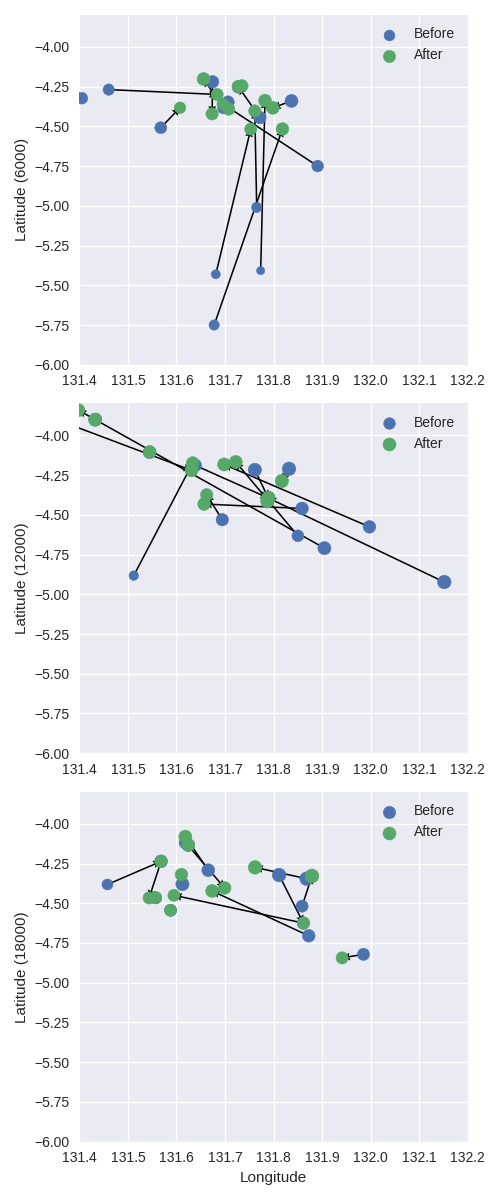

In [7]:
resampIdx = [6000, 12000, 18000 ]

fig,axs = plt.subplots(len(resampIdx))
fig.set_figheight(12)
fig.set_figwidth(5)
for j,ax in enumerate(axs.ravel()):
    idx = resampIdx[j]
    pre_lat   = np.array([ df['latitude' ][idx-2] for df in samples ])
    post_lat  = np.array([ df['latitude' ][idx+5] for df in samples ])
    pre_long  = np.array([ df['longitude'][idx-2] for df in samples ])
    post_long = np.array([ df['longitude'][idx+5] for df in samples ])
    pre_mag   = np.array([ df['magnitude'][idx-2] for df in samples ])
    post_mag  = np.array([ df['magnitude'][idx+5] for df in samples ])

    ax.quiver(pre_long,pre_lat,post_long-pre_long,post_lat-pre_lat,
              angles='xy',scale_units='xy',scale=1,width=0.004,headwidth=5)
    ax.scatter(pre_long,pre_lat,(pre_mag-8)*100,label='Before')
    ax.scatter(post_long,post_lat,(post_mag-8)*100,label='After')
    ax.set(ylabel='Latitude ('+str(idx)+')')
    ax.set_xlim(131.4, 132.2)
    ax.set_ylim(-6.0, -3.8)
    ax.legend()
    if j==2:
        ax.set(xlabel='Longitude')

plt.tight_layout()

<IPython.core.display.Javascript object>


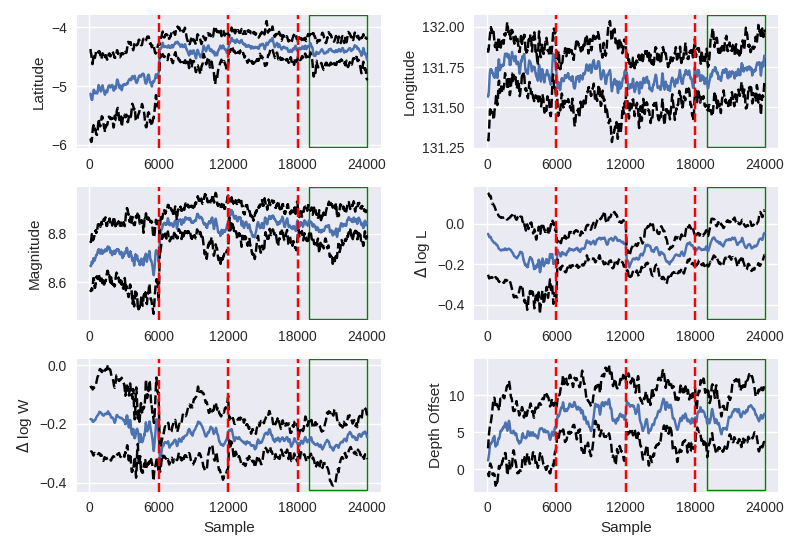

In [8]:
resampIdx = [6000, 12000, 18000 ]
window = 100

fig,axs = plt.subplots(3,2)
cols  = samples[0].columns
# ylabs = [col.title() for col in cols]; ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset"; 
ylabs = [col.replace("_"," ").replace("log","log ").title().replace("Log","log").replace("Delta","$\Delta$") for col in cols];
for j,ax in enumerate(axs.ravel()):
    col = cols[j]
    attr = ylabs[j]
    arrs = [ df[col].rolling(window).mean() for df in samples ]
    col_mean = np.mean(arrs, axis=0)
    col_std  = np.std(arrs, axis=0)
    ax.plot(col_mean)
    ax.plot(col_mean-col_std,'--k')
    ax.plot(col_mean+col_std,'--k')
    
    #add lines for resampling
    for idx in resampIdx:
        ax.axvline(x=idx, color='r', linestyle='--')
    
    #add box for samples used to compute posterior
    ymin,ymax = ax.get_ylim()
    bottom = ymin+0.01*(ymax-ymin) #adjust upward a tiny bit so whole bottom line shows
    height = ymax-ymin-0.01*(ymax-ymin) #shorten slightly so whole top line shows
    ax.add_patch(Rectangle((19000, bottom), 5000, height, linewidth=1, color="green",fill=False))
    
    #adjust axes
    ax.set(xticks=np.arange(0, 25000, step=6000))
    ax.set(ylabel=attr)
    if j>3:
        ax.set(xlabel='Sample')
    

plt.tight_layout()
plt.savefig('sampling.png')
plt.savefig('sampling.pdf')
plt.show()

# Gelman-Rubin

In [13]:
from functools import reduce

In [33]:
cutoff=18000

means = [df[cutoff:].expanding().mean() for df in samples]
_vars = [df[cutoff:].expanding().var() for df in samples]

W = reduce(lambda x, y: x.add(y), _vars)/len(_vars)
mean = reduce(lambda x, y: x.add(y), means)/len(means)

mean_vars = [(df-mean)**2 for df in means]
B = len(samples[0])*reduce(lambda x, y: x.add(y), mean_vars)/(len(mean_vars)-1)

var_hat = (1-(1/len(samples[0])))*W+(1/len(samples[0]))*B

R = (var_hat/W)**0.5

R

,latitude,longitude,magnitude,delta_logl,delta_logw,depth_offset
18000,NaN,NaN,NaN,NaN,NaN,NaN
18001,12.567428,10.732868,11.058676,36.019171,105.579040,23.427479
18002,7.922643,6.450280,3.561456,13.731229,31.902503,20.378482
18003,6.662819,5.563934,3.482157,12.972553,27.555689,17.974036
18004,5.823125,4.655649,3.240697,13.373800,18.628955,15.102669
...,...,...,...,...,...,...
23995,1.102408,1.054728,1.064192,1.184573,1.064857,1.093278
23996,1.102415,1.054741,1.064172,1.184543,1.064860,1.093250
23997,1.102422,1.054755,1.064152,1.184513,1.064862,1.093222
23998,1.102427,1.054770,1.064138,1.184483,1.064865,1.093196


<IPython.core.display.Javascript object>


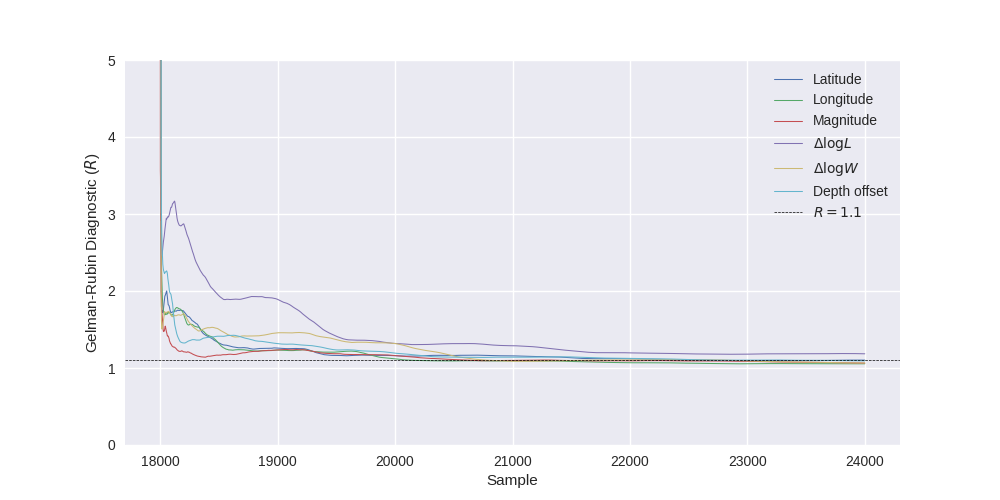

In [41]:
fig = plt.figure(figsize=(10,5))

parameters = {'latitude':'Latitude','longitude':'Longitude','magnitude':'Magnitude','delta_logl':'$\Delta \log L$',
              'delta_logw':'$\Delta \log W$','depth_offset':'Depth offset'}

for key in ['latitude','longitude','magnitude','delta_logl','delta_logw','depth_offset']:
    plt.plot(R[key],label=parameters[key],linewidth=.75)
plt.axhline(y=1.1, color='k', linestyle='--',label='$R=1.1$',linewidth=.5)
plt.ylim((0,5))
#ax.set(xlabel='Sample')
#ax.set(xlabel='Sample')
plt.xlabel('Sample')
plt.ylabel('Gelman-Rubin Diagnostic ($R$)')
plt.legend()
#plt.title('Gelman-Rubin Diagnostic')
# plt.show()
plt.savefig('gelman-rubin.png')
plt.savefig('gelman-rubin.pdf')